# Visualisations - Analyse des Alertes ANSSI & Enrichissement CVE

## Imports et nettoyage

### Imports et chemins

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tabulate import tabulate
from pathlib import Path

# Chemins
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_CSV     = PROJECT_ROOT / "data" / "processed" / "final_dataset.csv"
OUTPUT_DIR   = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("📁 Racine projet :", PROJECT_ROOT)
print("CSV présent :", DATA_CSV.exists(), "-", DATA_CSV)

📁 Racine projet : /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ
CSV présent : True - /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ/data/processed/final_dataset.csv


### Lecture et nettoyage du jeu de données

In [90]:
# Chargement initial
df_full = (
    pd.read_csv(
        DATA_CSV,
        parse_dates=["date", "closed_at", "cve_pub"],
        keep_default_na=False
    )
    .replace({"n/a": np.nan, "": np.nan})
)

# Typage numérique + explosion versions
for col in ["cvss_score","epss_score","epss_percentile","lag_anssi_days","days_open", "n_revisions"]:
    if col in df_full: df_full[col] = pd.to_numeric(df_full[col], errors="coerce")

# Vues à disposer
df_publi       = df_full.copy()                                             # toutes les lignes
df_clean       = df_full.dropna(subset=["cvss_score","epss_score"]).copy()  # pour scatter/violon…
df_unique_all  = (df_publi
                    .sort_values("date")
                    .drop_duplicates(subset=["cve"])
                    .copy())                                                   # pour cumuls, top vendors…
df_unique_scores = (df_clean
                      .sort_values("date")
                      .drop_duplicates(subset=["cve"])
                      .copy())                                                 # pour scatter unique,…

print("• df_publi       :", df_publi.shape)
print("• df_clean       :", df_clean.shape)
print("• df_unique_all  :", df_unique_all.shape)
print("• df_unique_scores:", df_unique_scores.shape)

• df_publi       : (257582, 22)
• df_clean       : (128407, 22)
• df_unique_all  : (38748, 22)
• df_unique_scores: (14756, 22)


## Exploration initiale du DataFrame

Avant de rentrer dans le cœur de nos visualisations, il est important d'explorer notre DataFrame afin d'avoir une première impression de la situation à analyser.

### Vue d'ensemble

In [91]:
print("Dimensions :", df_publi.shape)
display(df_publi.dtypes)
display(df_publi.head())
display(df_publi.tail())

Dimensions : (257582, 22)


id_anssi                   object
type                       object
titre                      object
n_revisions                 int64
date               datetime64[ns]
closed_at          datetime64[ns]
lien                       object
cve                        object
description                object
cvss_score                float64
cvss_sev                   object
cwe                        object
cwe_description            object
n_cve_refs                  int64
cve_pub            datetime64[ns]
lag_anssi_days            float64
epss_score                float64
epss_percentile           float64
vendor                     object
vendor_std                 object
produit                    object
days_open                   int64
dtype: object

,id_anssi,type,titre,n_revisions,date,closed_at,lien,cve,description,cvss_score,...,cwe_description,n_cve_refs,cve_pub,lag_anssi_days,epss_score,epss_percentile,vendor,vendor_std,produit,days_open
0,CERTFR-2023-AVI-0963,avis,Vulnérabilité dans les produits Cisco,1,2023-11-20,2025-06-18,https://www.cert.ssi.gouv.fr/avis/CERTFR-2023-...,CVE-2023-44487,The HTTP/2 protocol allows a denial of service...,NaN,...,NaN,140,2023-10-10,41.0,0.94434,0.99983,NaN,NaN,NaN,576
1,CERTFR-2025-AVI-0119,avis,Multiples vulnérabilités dans les produits Intel,1,2025-02-12,2025-06-18,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2024-38310,Improper access control in some Intel(R) Graph...,8.2,...,Escalation of Privilege,1,2025-02-12,0.0,0.00015,0.01816,NaN,NaN,Intel(R) Graphics Driver software installers,126
2,CERTFR-2025-AVI-0119,avis,Multiples vulnérabilités dans les produits Intel,1,2025-02-12,2025-06-18,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2024-25571,Improper input validation in some Intel(R) SPS...,2.3,...,Denial of Service,1,2025-02-12,0.0,0.00020,0.03603,NaN,NaN,Intel(R) SPS firmware before SPS_E5_06.01.04.0...,126
3,CERTFR-2025-AVI-0119,avis,Multiples vulnérabilités dans les produits Intel,1,2025-02-12,2025-06-18,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2023-34440,Improper input validation in UEFI firmware for...,7.5,...,Escalation of Privilege,1,2025-02-12,0.0,0.00028,0.06177,NaN,NaN,Intel(R) Processors,126
4,CERTFR-2025-AVI-0119,avis,Multiples vulnérabilités dans les produits Intel,1,2025-02-12,2025-06-18,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,CVE-2024-37020,Sequence of processor instructions leads to un...,3.8,...,Denial of Service,1,2025-02-12,0.0,0.00027,0.05858,NaN,NaN,Intel(R) Xeon(R) Processors,126


,id_anssi,type,titre,n_revisions,date,closed_at,lien,cve,description,cvss_score,...,cwe_description,n_cve_refs,cve_pub,lag_anssi_days,epss_score,epss_percentile,vendor,vendor_std,produit,days_open
257577,CERTFR-2020-AVI-012,avis,Multiples vulnérabilités dans Mozilla Firefox,1,2020-01-08,2020-01-08,https://cert.ssi.gouv.fr/avis/CERTFR-2020-AVI-012,CVE-2019-17024,Mozilla developers reported memory safety bugs...,NaN,...,Memory safety bugs fixed in Firefox 72 and Fir...,25,2020-01-08,0.0,0.02105,0.83253,Mozilla,Mozilla,Firefox ESR,0
257578,CERTFR-2020-AVI-012,avis,Multiples vulnérabilités dans Mozilla Firefox,1,2020-01-08,2020-01-08,https://cert.ssi.gouv.fr/avis/CERTFR-2020-AVI-012,CVE-2019-17024,Mozilla developers reported memory safety bugs...,NaN,...,Memory safety bugs fixed in Firefox 72 and Fir...,25,2020-01-08,0.0,0.02105,0.83253,Mozilla,Mozilla,Firefox,0
257579,CERTFR-2020-AVI-011,avis,Multiples vulnérabilités dans Tenable Tenable.sc,1,2020-01-08,2020-01-08,https://cert.ssi.gouv.fr/avis/CERTFR-2020-AVI-011,CVE-2019-3465,"Rob Richards XmlSecLibs, all versions prior to...",NaN,...,Improper Verification of Cryptographic Signature,15,2019-11-07,62.0,0.03746,0.87475,NaN,NaN,Rob Richards XmlSecLibs,0
257580,CERTFR-2020-AVI-010,avis,Vulnérabilité dans phpMyAdmin,1,2020-01-08,2020-01-08,https://cert.ssi.gouv.fr/avis/CERTFR-2020-AVI-010,CVE-2020-5504,NaN,NaN,...,NaN,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0
257581,CERTFR-2020-AVI-009,avis,Multiples vulnérabilités dans Google Chrome,1,2020-01-08,2020-01-08,https://cert.ssi.gouv.fr/avis/CERTFR-2020-AVI-009,NaN,NaN,NaN,...,NaN,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0


On remarque d'abord que le DataFrame comporte 203 538 lignes, ce qui, en partant d’environ 56 000 URL de bulletins, correspond bien au fait qu’un même bulletin peut lister plusieurs CVE ou produits.

### Valeurs manquantes

In [92]:
missing = df_publi.isna().sum().sort_values(ascending=False)
display(missing[missing > 0])

cvss_score         129077
cvss_sev           129077
cwe                 92651
cwe_description     92651
description         71997
vendor_std          44354
vendor              44354
produit             33735
epss_percentile     22583
epss_score          22583
cve_pub             21915
lag_anssi_days      21915
cve                   328
dtype: int64

On remarque de ce comptage que :
* EPSS (scores et percentiles) sont absents dans près de 2/3 des lignes (64 %), probablement car ce score n’existait pas avant fin 2020 et n’a été intégré que progressivement aux workflows.
* CVSS (score et sévérité) manquent dans plus de la moitié des cas (54 %), car certains bulletins ANSSI listent un CVE sans reprendre son score CVSS
* CWE et descriptions MITRE sont indisponibles pour ~40 % des vulnérabilités sûrement parce que de nombreuses CVE n’ont pas encore de « problemType » officiellement classé par MITRE (en particulier celles très récentes ou très anciennes)
* La quasi-intégralité des lignes (99,8 %) contiennent un identifiant CVE, ce qui est rassurant pour l’alignement avec les bases externes.

### Nombre de bulletins par type

In [93]:
display(df_publi["type"].value_counts())

type
avis      255882
alerte      1700
Name: count, dtype: int64

L’immense domination des avis est attendue et reflète la politique éditoriale de l’ANSSI. En effet, l'ANSSI déclenche une alerte seulement pour les CVE ayant un impact très élevé, ce qui explique leur extrême rareté. Tandis que les avis sont publiés de manière beaucoup plus systématique (régulièrement, parfois plusieurs fois par semaine) pour couvrir l’ensemble du spectre des vulnérabilités.

### Période couverte

In [94]:
print(df_publi["date"].min().date(), "→", df_publi["date"].max().date())

2020-01-02 → 2025-06-17


### Volume mensuel de publications ANSSI

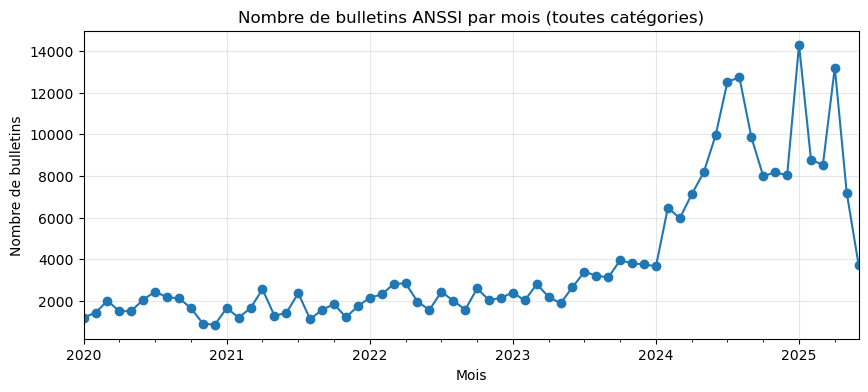

In [95]:
monthly_counts = df_publi.set_index("date")["type"].resample("ME").count()
plt.figure(figsize=(10,4))
monthly_counts.plot(marker="o")
plt.title("Nombre de bulletins ANSSI par mois (toutes catégories)")
plt.ylabel("Nombre de bulletins")
plt.xlabel("Mois")
plt.grid(alpha=0.3)
plt.show()

On remarque clairement deux tendances sur deux périodes :
* **2020 – mi-2023** : un rythme assez stable autour de 1 000–2 500 bulletins/mois, avec de petites crêtes ponctuelles (fin d’année, nouveaux gros correctifs Windows/Linux, etc.).
* **À partir de début 2024** : forte montée en charge, avec un palier à ≈ 4 000 bulletins en avril, puis une explosion fin printemps/été 2024 jusqu’à presque 9 500 en juin 2024. Les chiffres fluctuent entre 5000 et 9000 bulletins désormais. Le chiffre plus bas de bulletin au moins de juin est normal... car nous sommes en plein milieu !

### Distribution des scores CVSS et EPSS (tous bulletins)

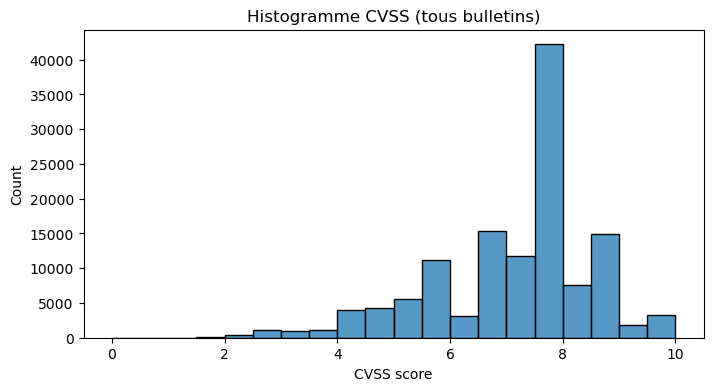

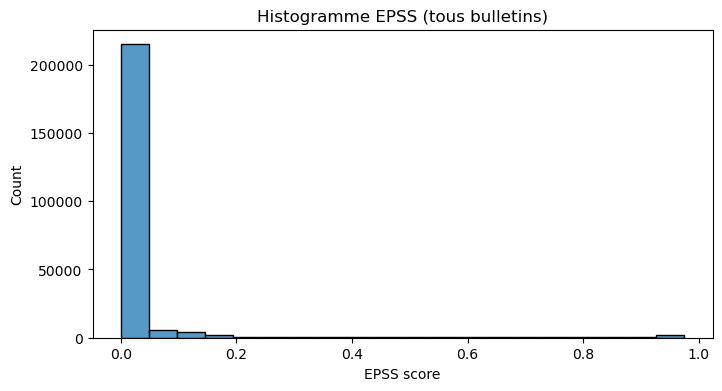

In [96]:
# CVSS
plt.figure(figsize=(8,4))
sns.histplot(df_publi["cvss_score"].dropna(), bins=20, kde=False)
plt.title("Histogramme CVSS (tous bulletins)")
plt.xlabel("CVSS score")
plt.show()

# EPSS
plt.figure(figsize=(8,4))
sns.histplot(df_publi["epss_score"].dropna(), bins=20, kde=False)
plt.title("Histogramme EPSS (tous bulletins)")
plt.xlabel("EPSS score")
plt.show()

Concernant la répartition des CVSS, on observe un pic principal entre 7 et 8 : la majorité des vulnérabilités traitées par CERT-FR ont un score CVSS "élevé" (7 ≤ CVSS < 9). On voit quelques vulnérabilités de sévérité "moyenne" (4 ≤ CVSS < 7), puis de plus en plus rares à très basse sévérité. Il y en a aussi quelques "critiques" mais pas majoritaires. Cela montre que CERT-FR couvre avant tout des failles à impact significatif, ce qui est cohérent avec son rôle d’alerte sur les vulnérabilités les plus dangereuses.

Pour les EPSS, il y a une forte concentration près de 0 : plus de 90 % des EPSS calculés sont très faibles (< 0,05), c’est-à-dire que la plupart des vulnérabilités n’ont, a priori, que peu de chances d’être exploitées dans les 30 jours. Un petit nombre de failles présentent des probabilités d’exploitation élevées, celles-ci méritent une attention prioritaire.

Ainsi, si la gravité (CVSS) est souvent élevée, la probabilité réelle d’exploitation est en pratique faible pour la plupart des CVE, exception faite de quelques vulnérabilités très ciblées par les attaquants.

## Analyse des vulnérabilités globales

### Scatter « CVSS × EPSS »

Nous cherchons à identifier des vulnérabilités à la fois graves ET probables, soit celles situées dans le quart supérieur droit du graphique.

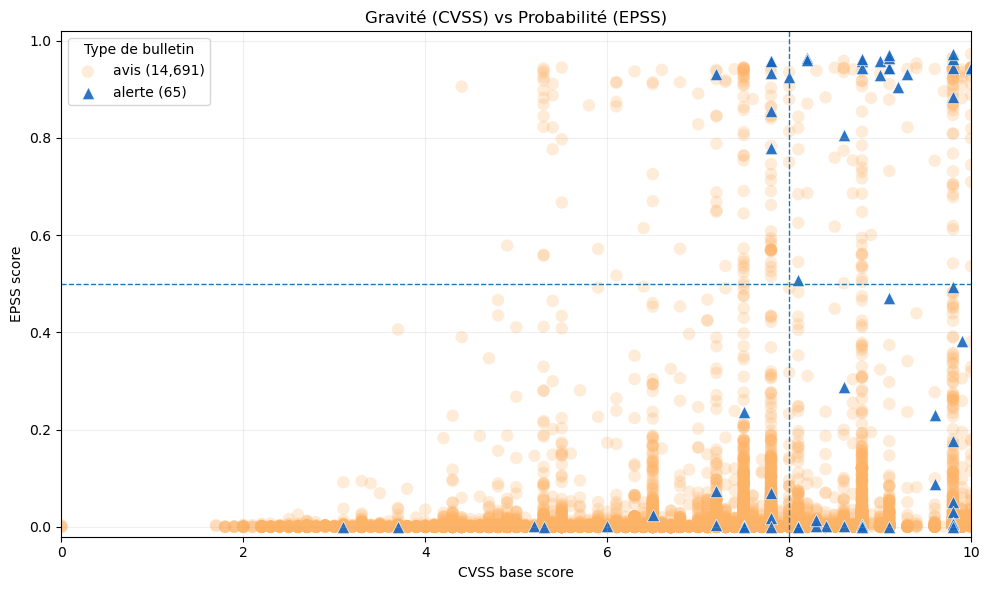

144 CVE urgentes enregistrées → /Users/doryandenis/Desktop/EFREI/Semestre 6/MasterCamp/Atelier DS/AtelierDS_PRJ/outputs/urgences_cve.csv


In [97]:
plt.figure(figsize=(10, 6))

# Styles
palette = {"avis": "#FDB366", "alerte": "#1565C0"}
markers = {"avis": "o",       "alerte": "^"}
alphas  = {"avis": 0.25,      "alerte": 0.9}
size_pt = 80  # taille fixe pour tous les points

for typ in ("avis", "alerte"):
    sub = df_unique_scores[df_unique_scores["type"] == typ]
    plt.scatter(
        sub["cvss_score"], sub["epss_score"],
        s=size_pt,
        c=palette[typ],
        marker=markers[typ],
        alpha=alphas[typ],
        edgecolors="white" if typ == "alerte" else "none",
        linewidths=0.5 if typ == "alerte" else 0,
        label=f"{typ} ({len(sub):,})"
    )

# Seuils critiques
plt.axvline(8, linestyle="--", linewidth=1)
plt.axhline(0.5, linestyle="--", linewidth=1)

plt.xlabel("CVSS base score")
plt.ylabel("EPSS score")
plt.title("Gravité (CVSS) vs Probabilité (EPSS)")
plt.xlim(0, 10)
plt.ylim(-0.02, 1.02)
plt.legend(title="Type de bulletin")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Export des CVE « urgentes »
urg = df_unique_all[
    (df_unique_all["cvss_score"] >= 8) &
    (df_unique_all["epss_score"] >= 0.5)
]
urg.to_csv(OUTPUT_DIR / "urgences_cve.csv", index=False, encoding="utf-8")
print(f"{len(urg):,} CVE urgentes enregistrées → {OUTPUT_DIR/'urgences_cve.csv'}")

Tout d'abord, on retrouve au niveau du positionnement des avis la même dynamique que dans les histogrammes faits durant la phase d'exploraton. En effet, la majorité d'entre eux sont dispersés sur toute la gamme de CVSS (2–10), mais la densité la plus forte se trouve autour de CVSS 7–8 avec EPSS très bas (< 0.2).

Dans la zone "critique" (en haut à droite), on y trouve une poignée d’avis (par rapport au nombre total représenté) et presque toutes les alertes. Ce sont les vraies urgences où l’impact technique ET la probabilité d’attaque sont élevés, ce qui est cohérent avec nos observations antérieures.

Ainsi, le principal message qui ressort de la visualisation est qu'il est important de ne pas s'alarmer systématiquement dès qu’un CVSS arrive à 9 car si l’EPSS est quasi nulle, l’urgence opérationnelle est limitée.
Aussi notre fenêtre critique pourrait constituer notre étiquette positive idéale pour entraîner un classifieur binaire à prédire cette criticité à partir des seules features CVSS, EPSS, days_open, n_cve_refs, vendor_std, etc.

### Violin plot EPSS par quartile CVSS

On cherche ici à savoir si les vulnérabilités les plus graves (CVSS élevé) sont aussi les plus susceptibles d’être exploitées (EPSS élevé). Cette visualisation permet donc de voir la densité des valeurs EPSS dans chaque groupe CVSS (Q1 à Q4), et d’observer leur dispersion, asymétrie, et tendance centrale.

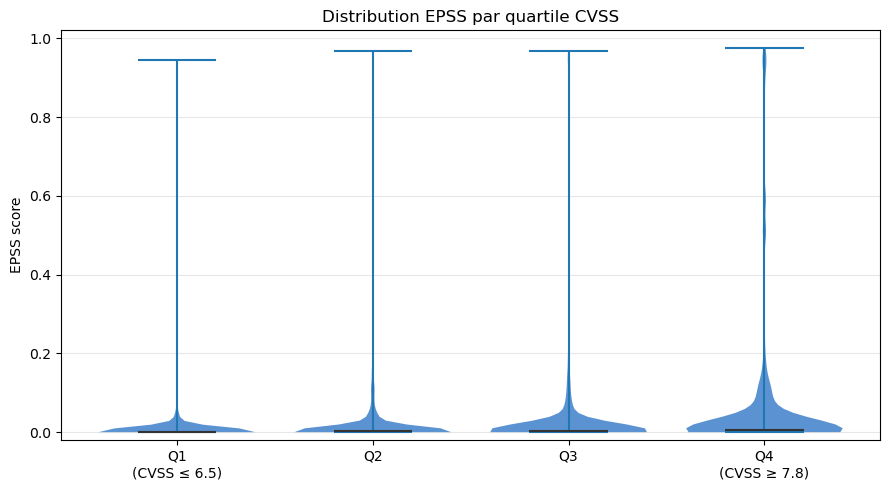

In [98]:
d = df_clean.copy()

# Quartiles
d["cvss_quartile"] = pd.qcut(
    d["cvss_score"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

# Liste des séries EPSS par quartile
grouped_epss = [
    d.loc[d["cvss_quartile"] == q, "epss_score"]
    for q in ["Q1", "Q2", "Q3", "Q4"]
]

# Plot
plt.figure(figsize=(9, 5))
parts = plt.violinplot(
    grouped_epss,
    showmeans=False,
    showmedians=True,
    widths=0.8
)

for pc in parts["bodies"]:
    pc.set_facecolor("#1565C0")
    pc.set_alpha(0.7)

parts["cmedians"].set_color("#333333")

q25 = d["cvss_score"].quantile(0.25)
q75 = d["cvss_score"].quantile(0.75)
quartile_labels = [
    f"Q1\n(CVSS ≤ {q25:.1f})",
    "Q2",
    "Q3",
    f"Q4\n(CVSS ≥ {q75:.1f})",
]

plt.xticks([1, 2, 3, 4], quartile_labels)
plt.ylabel("EPSS score")
plt.title("Distribution EPSS par quartile CVSS")
plt.ylim(-0.02, 1.02)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Dans les quartiles bas (Q1–Q3), les densités sont très concentrées près de zéro : la quasi-totalité des failles de CVSS ≤ 7,8 ont une EPSS très faible, allant jusqu'à maximim 0,2. Cela montre que les failles de gravité faible à moyenne sont rarement exploitables.

En revanche, dans le quartile élevé (Q4, CVSS ≥ 7,8), la distribution s’élargit nettement car on voit une plus grande épaisseur autour de 0,6 et entre 0,9 et 1,0, signe que parmi les failles très graves, une part non négligeable d'entre elles sont également très exploitables. Bien entendu la majorité de la distribution reste proche de 0 mais la queue haute est beaucoup plus marquée qu’en Q1–Q3.

Ce constat s'aligne avec ceux de la visualisation précédente et suggère que dans le cas d'un clustering, on pourrait d’emblée isoler le cluster Q4 avec EPSS élevé pour le traiter différemment (alerting prioritaire), et réserver un traitement secondaire aux clusters Q1–Q3.

### Histogramme empilé des scores CVSS

On cherche ici à analyser la distribution des niveaux de gravité CVSS (Common Vulnerability Scoring System) des vulnérabilités documentées dans les bulletins avis et alertes de l’ANSSI. On peut ainsi visualiser les plages de gravité les plus fréquentes et identifier les zones critiques (CVSS ≥ 7, 8 ou 9), souvent associées à des failles exploitables ou très graves.

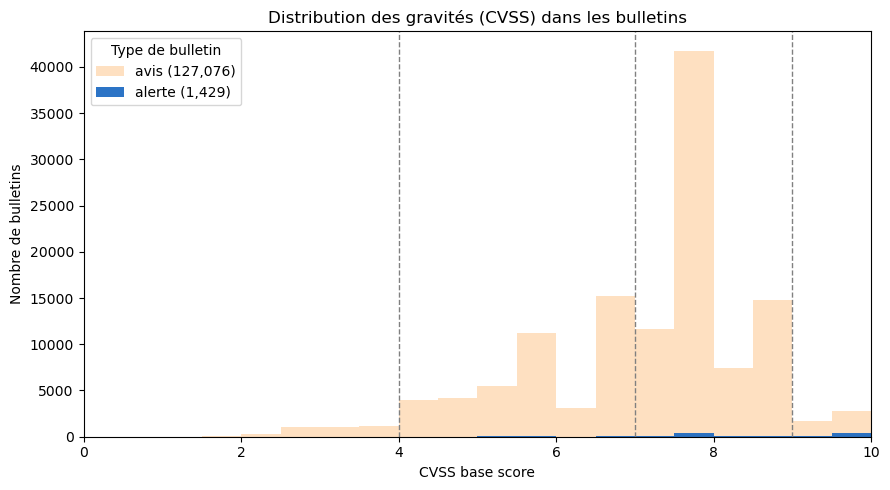

In [99]:
avis_cvss    = df_publi[df_publi["type"] == "avis"]["cvss_score"].dropna()
alertes_cvss = df_publi[df_publi["type"] == "alerte"]["cvss_score"].dropna()

bins = np.arange(0, 10.5, 0.5)

plt.figure(figsize=(9, 5))

# Avis
plt.hist(
    avis_cvss,
    bins=bins,
    color="#FDB366",
    alpha=0.4,
    label=f"avis ({len(avis_cvss):,})",
)

# Alertes
plt.hist(
    alertes_cvss,
    bins=bins,
    color="#1565C0",
    alpha=0.9,
    label=f"alerte ({len(alertes_cvss):,})",
    stacked=True,
)

# Lignes seuils
for x in (4, 7, 9):
    plt.axvline(x, linestyle="--", color="grey", linewidth=1)

plt.xlabel("CVSS base score")
plt.ylabel("Nombre de bulletins")
plt.title("Distribution des gravités (CVSS) dans les bulletins")
plt.xlim(0, 10)
plt.legend(title="Type de bulletin")
plt.tight_layout()
plt.show()

On remarque déjà une concentration très forte des avis autour de CVSS 7,5–8,0 : l’ANSSI publie majoritairement des avis pour des vulnérabilités jugées élevées mais pas forcément urgentes. On voit un second pic bien plus petit en 8,5–9,0 et encore un creux relatif au-delà de 9,0. Les avis pour CVSS < 4 restent marginaux, ce qui est cohérent : on informe moins quand la gravité est faible.

Ensuite, le plus grand nombre d’alertes se situe aussi dans 7,5–8,0, mais proportionnellement aux avis, elles représentent un segment extrêmement restreint. On retrouve une seconde zone d’alerte significative pour CVSS 9,5–10,0, puis 9,0–9,5, ce sont les vulnérabilités les plus critiques. En revanche, aucune alerte sous CVSS 2,5 : le seuil minimal pour qu’un problème devienne alerte se situe clairement autour de 5–6, et surtout au-delà.

Cette visualisation valide l’idée que CVSS ≥ 9,5 est un signal fort pour déclencher automatiquement une notification email critique, sans traitement manuel.

### Courbe cumulative des vulnérabilités en fonction du temps

On cherche à suivre l’évolution dans le temps du volume total de vulnérabilités recensées par l’ANSSI et comparer les dynamiques des deux types de bulletins (avis et alertes).

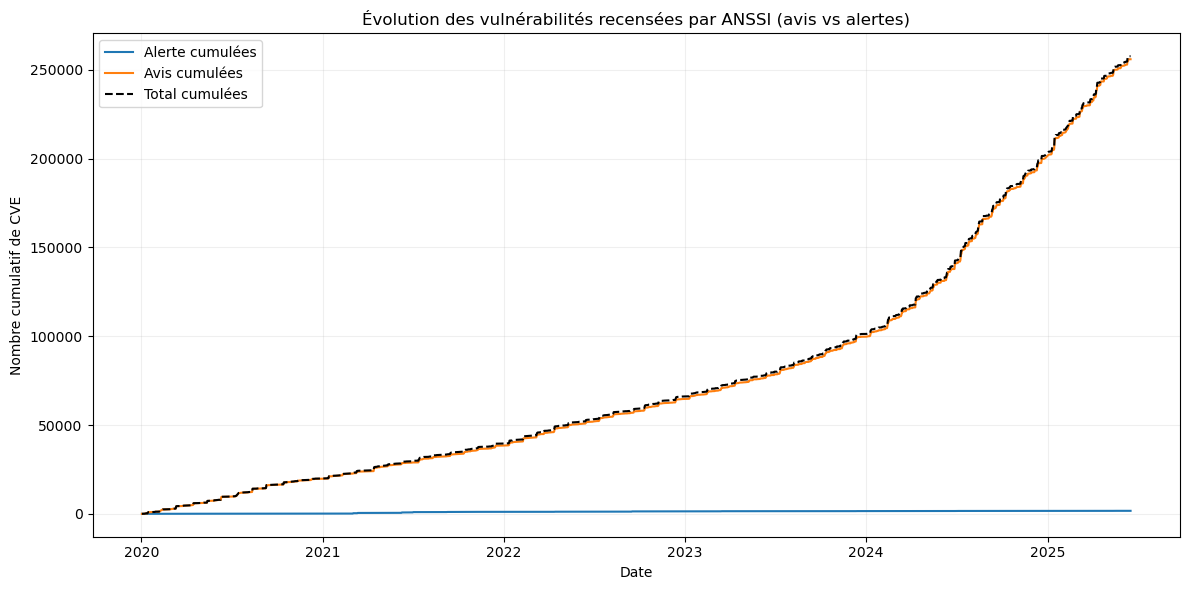

In [100]:
# On regroupe par date et par type, on compte, on trie, puis on cumule  
vuln_cum_par_type = (
    df_publi
      .groupby(["date", "type"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
      .cumsum()
)

# On calcule aussi le total des vulnérabilités cumulées
vuln_cum_total = (
    df_publi
      .groupby("date")
      .size()
      .sort_index()
      .cumsum()
)

# 2️⃣ Tracé
plt.figure(figsize=(12, 6))

# courbes pour chaque type
for bulletin_type in vuln_cum_par_type.columns:
    plt.plot(
        vuln_cum_par_type.index,
        vuln_cum_par_type[bulletin_type],
        label=f"{bulletin_type.capitalize()} cumulées"
    )

# courbe globale
plt.plot(
    vuln_cum_total.index,
    vuln_cum_total.values,
    color="black",
    linestyle="--",
    label="Total cumulées"
)

plt.xlabel("Date")
plt.ylabel("Nombre cumulatif de CVE")
plt.title("Évolution des vulnérabilités recensées par ANSSI (avis vs alertes)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

On remarque une évolution presque linéaire entre 2020 et 2024 des vulnérabiloités recensées. Toutefois, à partir de 2024, on observe une accentuation de la pente : le nombre de CVE recensées par mois augmente plus rapidement, ce qui indique la hausse de la fréquence des bulletins publiés (déjà visible dans la courbe mensuelle en exploration).

### Stacked Area : Total des vulnérabilités vs subsets "CVSS >= 8 et EPSS >= 0.5"

Nous cherchons ici à suivre mensuellement l’évolution du volume de vulnérabilités, tout en mettant en évidence :
* Les vulnérabilités "dangereuses" (CVSS ≥ 8),
* Les vulnérabilités "urgentes" (EPSS ≥ 0.3),
* Et surtout les vulnérabilités "critiques", cumulant CVSS ≥ 8 et EPSS ≥ 0.3.

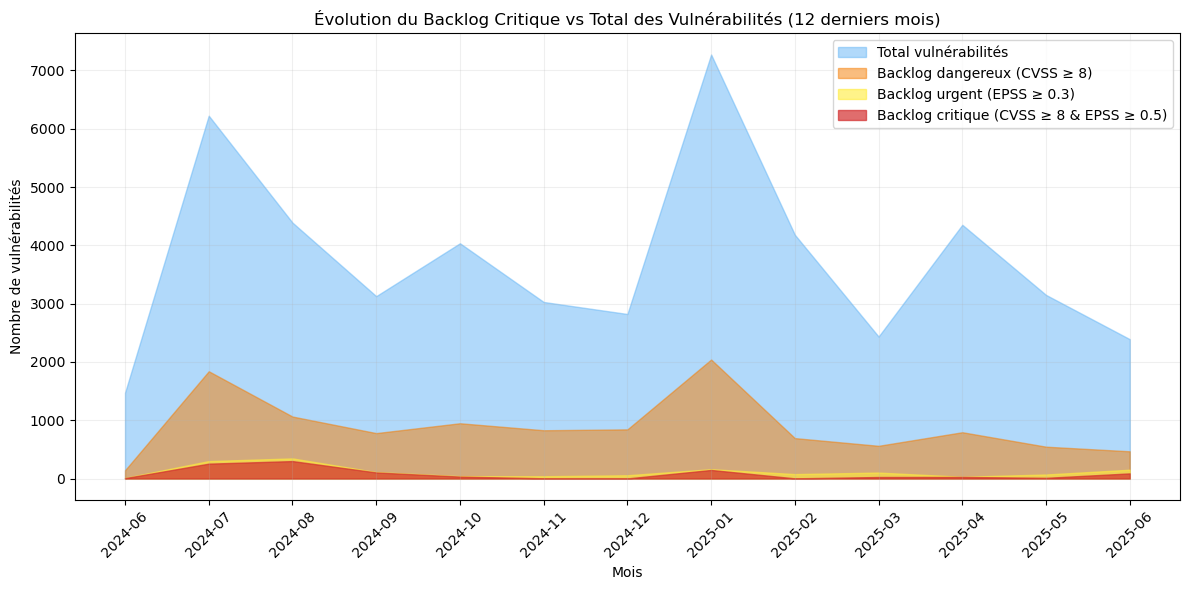


Données mensuelles (12 derniers mois) :
         total  danger  urgent  critical
month                                   
2024-06   1472     142      10         7
2024-07   6223    1840     299       255
2024-08   4389    1063     345       299
2024-09   3128     779     110       104
2024-10   4035     948      40        33
2024-11   3028     828      39         4
2024-12   2822     843      56         2
2025-01   7272    2041     160       147
2025-02   4181     693      76         3
2025-03   2435     561     102        26
2025-04   4352     794      30        27
2025-05   3149     546      69        12
2025-06   2390     467     151        88


In [101]:
# Filtrer les CVE avec des scores valides
df_valid_scores = df_clean.dropna(subset=["cvss_score", "epss_score"]).copy()

# Définir la date limite (12 mois avant aujourd’hui)
date_limite = pd.Timestamp.now() - pd.DateOffset(months=12)

# Filtrer dans df_valid_scores (CVE dédupliquées)
df_recent = df_valid_scores[df_valid_scores["date"] >= date_limite].copy()

# Regrouper par mois
df_recent["month"] = df_recent["date"].dt.to_period("M")

# Total CVE par mois
monthly_total = df_recent.groupby("month").size()

# Subset dangereux
danger = df_recent[(df_recent["cvss_score"] >= 8)]
monthly_danger = danger.groupby("month").size()

# Subset urgent (EPSS ≥ 0.3)
urgent = df_recent[(df_recent["epss_score"] >= 0.3)]
monthly_urgent = urgent.groupby("month").size()

# Subset critique
critical = df_recent[(df_recent["cvss_score"] >= 8) & (df_recent["epss_score"] >= 0.3)]
monthly_critical = critical.groupby("month").size()


# Aligner les index
all_months = monthly_total.index.union(monthly_critical.index).sort_values()
monthly_total = monthly_total.reindex(all_months, fill_value=0)
monthly_danger = monthly_danger.reindex(all_months, fill_value=0)
monthly_urgent = monthly_urgent.reindex(all_months, fill_value=0)
monthly_critical = monthly_critical.reindex(all_months, fill_value=0)


# Tracé Stacked Area
plt.figure(figsize=(12, 6))
plt.fill_between(all_months.astype(str), monthly_total.values, color="#64B5F6", alpha=0.5, label="Total vulnérabilités")
plt.fill_between(all_months.astype(str), monthly_danger.values, color="#F57C00", alpha=0.5, label="Backlog dangereux (CVSS ≥ 8)")
plt.fill_between(all_months.astype(str), monthly_urgent.values, color="#FFEB3B", alpha=0.6, label="Backlog urgent (EPSS ≥ 0.3)")
plt.fill_between(all_months.astype(str), monthly_critical.values, color="#D32F2F", alpha=0.7, label="Backlog critique (CVSS ≥ 8 & EPSS ≥ 0.5)")

plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.title("Évolution du Backlog Critique vs Total des Vulnérabilités (12 derniers mois)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

stats = pd.DataFrame({
    "total":       monthly_total,
    "danger":      monthly_danger,
    "urgent":      monthly_urgent,
    "critical":    monthly_critical
})
print("\nDonnées mensuelles (12 derniers mois) :")
print(stats.to_string())

Le volume total de CVE recensées passe de ~300 CVE en juin 2024 à plus de 1 100 CVE en juillet 2024, puis redescend à ~350–800 CVE les mois suivants avant de remonter à 1 140 CVE en juin 2025. Cette oscillation suggère des périodes fortes de publication ANSSI, peut être liées à des crises de sécurité ou à des vagues de divulgations groupées, suivies de phases plus calmes.

Le nombre de vulnérabilités à CVSS ≥ 8 grimpe à 323 en juillet 2024, puis se stabilise autour de 100–350 par mois. En moyenne, ~20–30 % des CVE mensuelles sont critiques techniquement.

Les failles jugées exploitables à court terme (EPSS ≥ 0.3) restent nettement moins nombreuses que les CVSS ≥ 8 : on passe de 144 urgences en juillet 2024 à seulement 7 en octobre/novembre, puis à 74 en juin 2025. Ce glissement montre que toutes les vulnérabilités à haute sévérité ne sont pas immédiatement perçues comme exploitables sur le terrain, ce qui peut guider la priorisation.

Enfin, les vulnérabilités cumulant à la fois un très fort impact et une forte probabilité d’exploitation varient de 0 à 124 en juillet 2024, avec un creux à 0 en février 2025, et 35 en juin 2025. Ces cas représentent généralement 1 % à 10 % du total mensuel. Elles constituent nos vraies urgences et devraient déclencher des alertes email immédiates.

## Analyse des faiblesses (CWE)

### Top 15 des faiblesses (CWE)

On cherche à identifier les CWE les plus fréquemment associées à des CVE et croiser cette fréquence avec la dangerosité potentielle, mesurée par la moyenne du score EPSS.

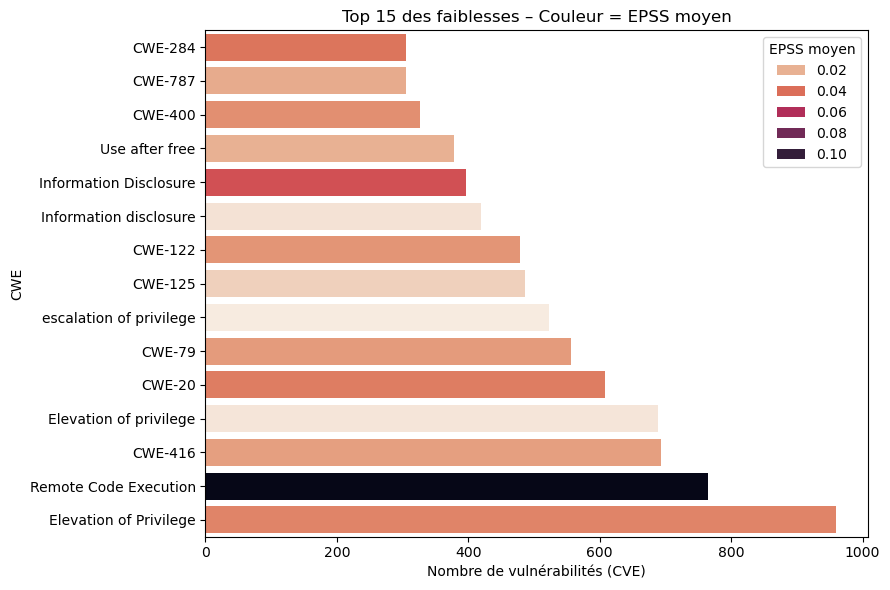

Données du Top 15 des faiblesses (CWE) :
                    cwe  nb  epss_moy
                CWE-284 305  0.037862
                CWE-787 306  0.021885
                CWE-400 327  0.030530
         Use after free 378  0.019930
 Information Disclosure 397  0.048492
 Information disclosure 419  0.004004
                CWE-122 478  0.028622
                CWE-125 487  0.009889
escalation of privilege 523  0.001210
                 CWE-79 557  0.026599
                 CWE-20 608  0.035665
 Elevation of privilege 689  0.003257
                CWE-416 694  0.025338
  Remote Code Execution 765  0.116715
 Elevation of Privilege 960  0.033664


In [102]:
# 1) filtrer lignes disposant d’un CWE
d_cwe = df_unique_all.dropna(subset=["cwe"])

# 2) agrégation : nombre de CVE et EPSS moyen
top_cwe = (
    d_cwe.groupby("cwe", as_index=False)
         .agg(nb=("cwe", "size"),
              epss_moy=("epss_score", "mean"))
         .sort_values("nb", ascending=False)
         .head(15)
         .sort_values("nb")          # pour plot horizontal ascendant
)

# 3) barplot horizontal, palette graduée sur l’EPSS moyen
plt.figure(figsize=(9, 6))
sns.barplot(
    data=top_cwe,
    x="nb",
    y="cwe",
    hue="epss_moy",
    palette="rocket_r",
    dodge=False
)

plt.xlabel("Nombre de vulnérabilités (CVE)")
plt.ylabel("CWE")
plt.title("Top 15 des faiblesses – Couleur = EPSS moyen")
plt.legend(title="EPSS moyen", loc="upper right")
plt.tight_layout()
plt.show()

print("Données du Top 15 des faiblesses (CWE) :")
print(top_cwe.to_string(index=False, columns=["cwe", "nb", "epss_moy"]))

On remarque que Remote Code Execution (RCE) arrive en 2ᵉ position avec 796 CVE et un EPSS moyen assez élevé (0,128). C’est la classe la plus à même d’être exploitée en pratique, en plus d’être abondante : à surveiller en priorité.

Elevation of Privilege (dans sa forme canonique) domine avec 1 017 CVE mais un EPSS moyen moindre. Cela montre que beaucoup de failles de ce type sont repérées, mais elles sont en moyenne moins exploitées que les RCE.

Viennent ensuite des CWE “génériques” :
* CWE-416 (Use After Free)
* CWE-20 (Input Validation) 
* CWE-79 (Cross-Site Scripting) 

### Courbe de l'évolution de différent CWE au cours du temps

L’objectif de cette visualisation est de suivre la dynamique temporelle des vulnérabilités associées à certaines failles critiques identifiées par leur identifiant CWE. On a pris les 5 plus fréquentes selon la visualisation précédente.

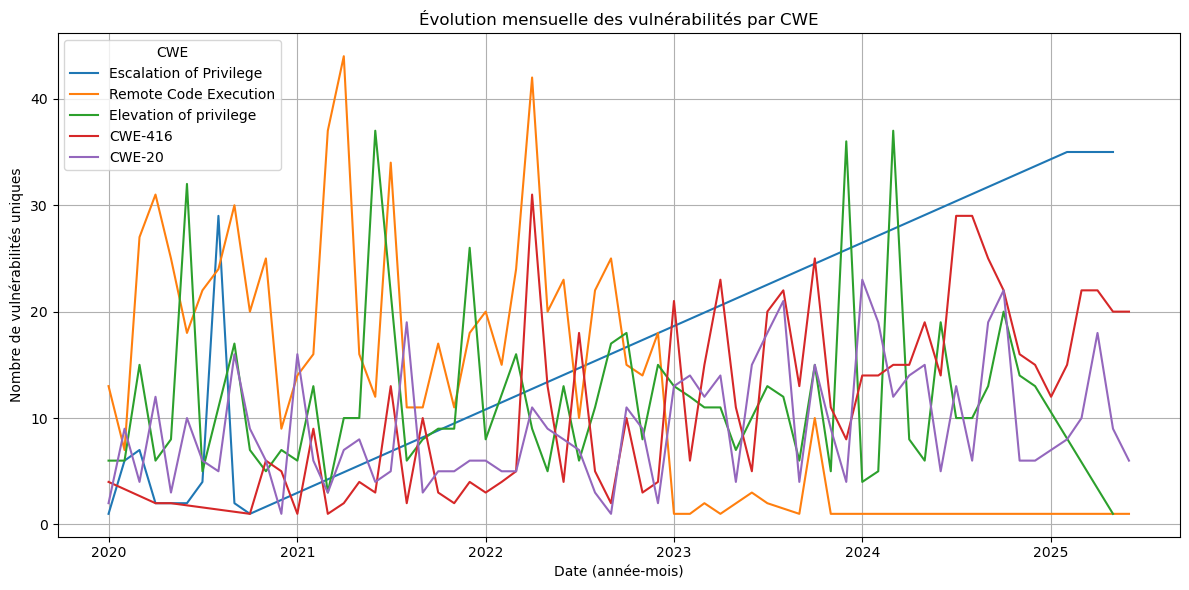

In [103]:
cwe_list = ["Escalation of Privilege", "Remote Code Execution", "Elevation of privilege", "CWE-416", "CWE-20"]

plt.figure(figsize=(12, 6))

for cwe in cwe_list:
    temp = df_unique_all[df_unique_all["cwe"] == cwe].copy()
    temp["date"] = pd.to_datetime(temp["date"], errors='coerce')
    temp = temp.dropna(subset=["date"])
    
    # Extraire l’année + mois
    temp["year_month"] = temp["date"].dt.to_period("M")
    
    # Compter le nombre de vulnérabilités par mois
    counts = temp["year_month"].value_counts().sort_index()
    
    # Convertir pour le tracé
    counts.index = counts.index.to_timestamp()
    
    plt.plot(counts.index, counts.values, label=cwe)

plt.title("Évolution mensuelle des vulnérabilités par CWE")
plt.xlabel("Date (année-mois)")
plt.ylabel("Nombre de vulnérabilités uniques")
plt.legend(title="CWE")
plt.grid(True)
plt.tight_layout()
plt.show()


Mis à part Escalation of Privilege qui montre globalement une évolution pluôt constante malgré un pic en mi 2020, le reste des CWE principales montrent des fluctuations globalement entre 0 et 30 vulnérabilités. On remarque entre autres des pics jusqu'à 40 pour Remote Code Execution et une 

### Boxplot entre days_open et CWE

On cherche à répondre à la question : Quelles failles mettent le plus de temps à être traitées ?
Le nombre de jours ouverts (days_open) représente le temps entre la publication et la fermeture d'une CVE.

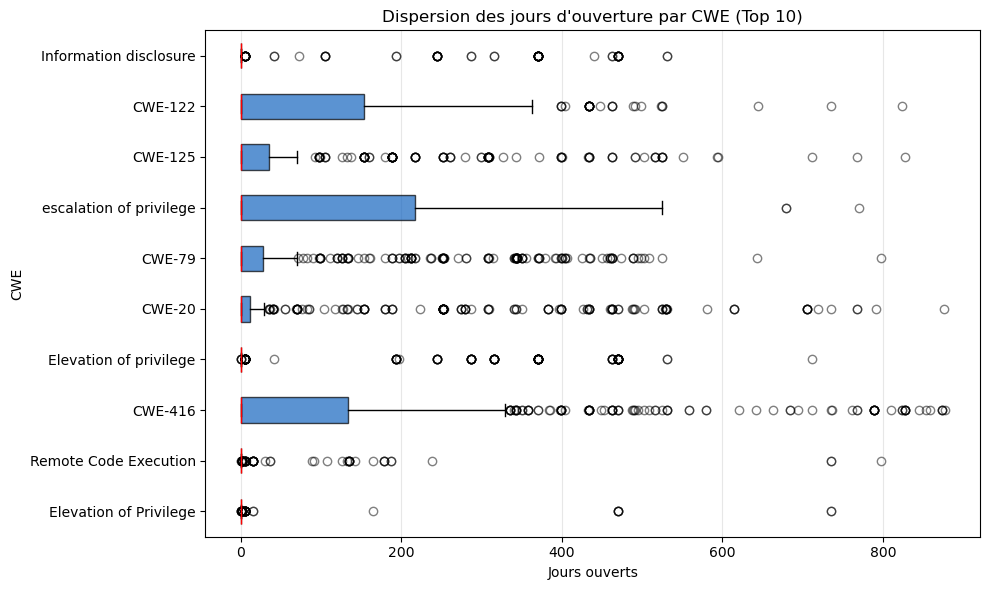

In [104]:
# ─── Préparation des données ──────────────────────────────────────────
# Assurons-nous que days_open est numérique et sans NaN
df_unique_all["days_open"] = pd.to_numeric(df_unique_all["days_open"], errors="coerce")
df_unique1 = df_unique_all.dropna(subset=["days_open", "cwe"])

# On récupère les 10 CWE les plus fréquents
top_10_cwe = df_unique_all["cwe"].value_counts().head(10).index.to_list()

# Subset limité au top 10
subset = df_unique1[df_unique1["cwe"].isin(top_10_cwe)].copy()

# Définition de l'ordre (du plus fréquent au moins fréquent)
cwe_order = (
  subset["cwe"]
    .value_counts()
    .loc[top_10_cwe]   # conserve l’ordre du top_10_cwe
    .index
    .tolist()
)

# ─── Tracé du boxplot avec matplotlib ─────────────────────────────────
plt.figure(figsize=(10, 6))

# Création du boxplot
plt.boxplot(
  [subset[subset["cwe"] == cwe]["days_open"] for cwe in cwe_order],
  vert=False,  # Boxplot horizontal
  patch_artist=True,  # Remplissage des boîtes
  boxprops=dict(facecolor="#1565C0", alpha=0.7),  # Couleur des boîtes
  medianprops=dict(color="red"),  # Couleur de la médiane
  flierprops=dict(marker="o", color="orange", alpha=0.5),  # Outliers
)

# Ajout des labels
plt.yticks(range(1, len(cwe_order) + 1), cwe_order)
plt.xlabel("Jours ouverts")
plt.ylabel("CWE")
plt.title("Dispersion des jours d'ouverture par CWE (Top 10)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

On observe certaines failles avec des délais de traitement plus courts comme CWE-416 (Use After Free) qui a une médiane autour de 300 jours, avec une dispersion relativement concentrée, malgré quelques outliers. Cela montre que cette vulnérabilité est traitée de manière assez standard malgré son importance, probablement grâce à des outils d'analyse de mémoire automatisés.

Mais on a aussi des failles avec durée d’exposition plus longue ou plus variable comme CWE-400 (Resource Exhaustion) qui possède une forte dispersion, et une présence d’outliers significatifs > 800 jours. Il peut d'agir de vulnérabilités parfois sous-estimées ou difficiles à reproduire dans un environnement de test.

On a également le cas du CWE-476 (NULL Pointer Dereference) avec une très courte durée médiane et très peu de dispersion. Cela peut indiquer une détection rapide et une résolution facilitée (un crash évident par exemple).

Grâce à cette visualisation, on peut hiérarchiser les failles à résorber rapidement : les CWE avec des durées longues et des écarts importants méritent une surveillance accrue ou des politiques de remédiation renforcées.

### Histogrammes des principales vulnérabilités sur Apple

Cette visualisation vise à identifier les types de vulnérabilités les plus fréquemment rencontrées chez Apple, en se basant sur les descriptions associées aux CWE.

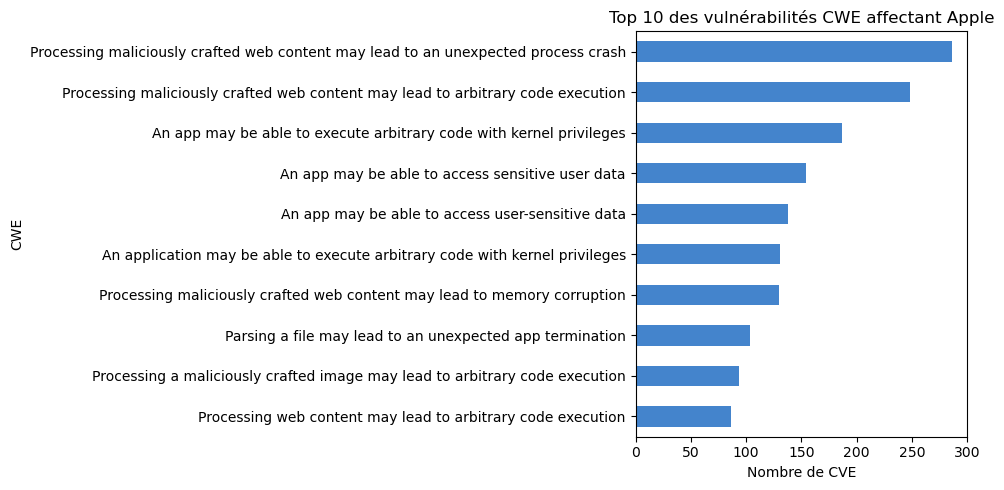

In [105]:
# 🔍 Filtrage des lignes où le vendor_std contient "apple" (insensible à la casse)
df_apple = df_publi[df_publi["vendor_std"].str.contains("apple", case=False, na=False)].copy()

# 🧼 On garde les lignes avec une CWE valide
df_apple = df_apple.dropna(subset=["cwe"])

# Si aucun résultat, on affiche un message
if df_apple.empty:
    print("⚠️  Aucun CVE avec vendor_std contenant 'apple' trouvé dans le dataset.")
else:
    # 📊 Compte des CWE affectant Apple
    top_cwe_apple = df_apple["cwe"].value_counts().head(10)

    # 📈 Affichage
    plt.figure(figsize=(10, 5))
    top_cwe_apple.plot(kind="barh", color="#1565C0", alpha=0.8)
    plt.title("Top 10 des vulnérabilités CWE affectant Apple")
    plt.xlabel("Nombre de CVE")
    plt.ylabel("CWE")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

Les 3 vulnérabilités les plus fréquentes sont :
* “Processing maliciously crafted web content may lead to an unexpected process crash” (~85 CVE)
    
    → Il s'agit d'une vulnérabilité fréquente dans les moteurs de rendu et peut être exploitée à distance via le navigateur ou les vues intégrées dans les apps.

* “An app may be able to access sensitive user data” (~75 CVE)
    
    → Risque direct pour la vie privée, contournement des mécanismes de sandboxing ou de permissions.

* “An app may be able to access user-sensitive data” (~60 CVE)
    
    → Formulation voisine de la précédente, indiquant une faille structurelle dans la gestion des accès aux données sur les appareils Apple.

On observe que chez Apple, les vulnérabilités se concentrent autour des crashs provoqués par contenu malicieux (notamment web), de l’exposition involontaire de données utilisateur et de l’élargissement abusif des droits d’accès des apps.

## Analyse par éditeur / fournisseur

### Histogramme des vendeurs les plus affectés par CVE distincts

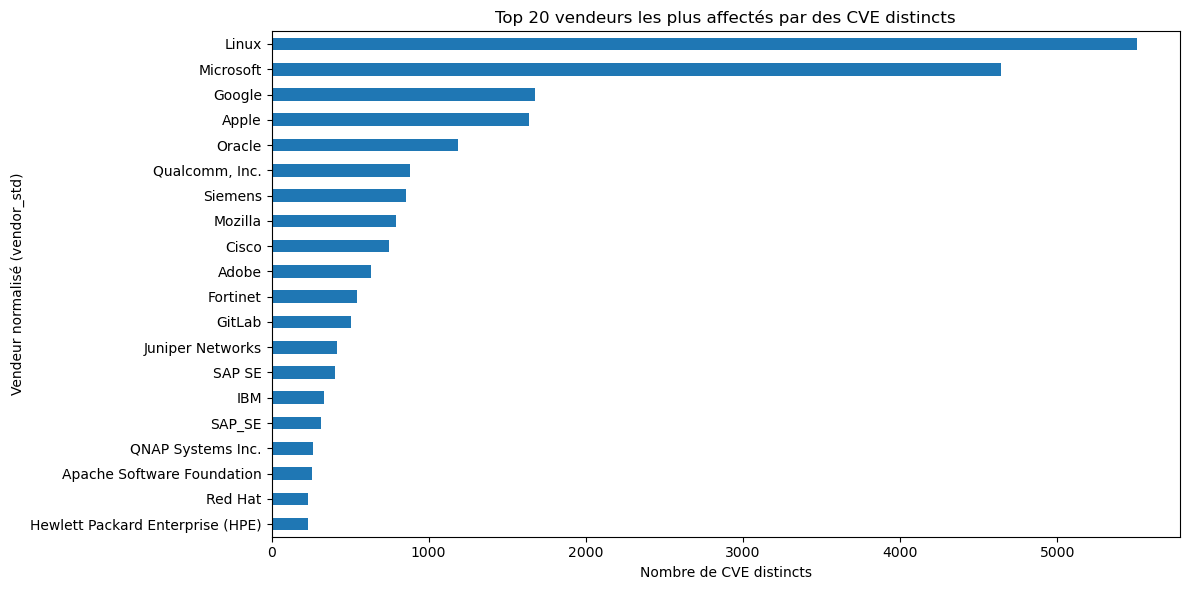

In [106]:
# On filtre les lignes ayant un vendor_std et une cve valides
df_cve = df_publi.dropna(subset=["vendor_std", "cve"]).copy()

# Compte du nombre de CVE distincts par vendor_std
cve_par_vendor = (
    df_cve.groupby("vendor_std")["cve"]
    .nunique()
    .sort_values(ascending=False)
    .head(20)
)

# Affichage du graphique
plt.figure(figsize=(12, 6))
cve_par_vendor.plot(kind="barh")
plt.title("Top 20 vendeurs les plus affectés par des CVE distincts")
plt.xlabel("Nombre de CVE distincts")
plt.ylabel("Vendeur normalisé (vendor_std)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Histogramme des vendeurs les plus affectés par CWE distincts

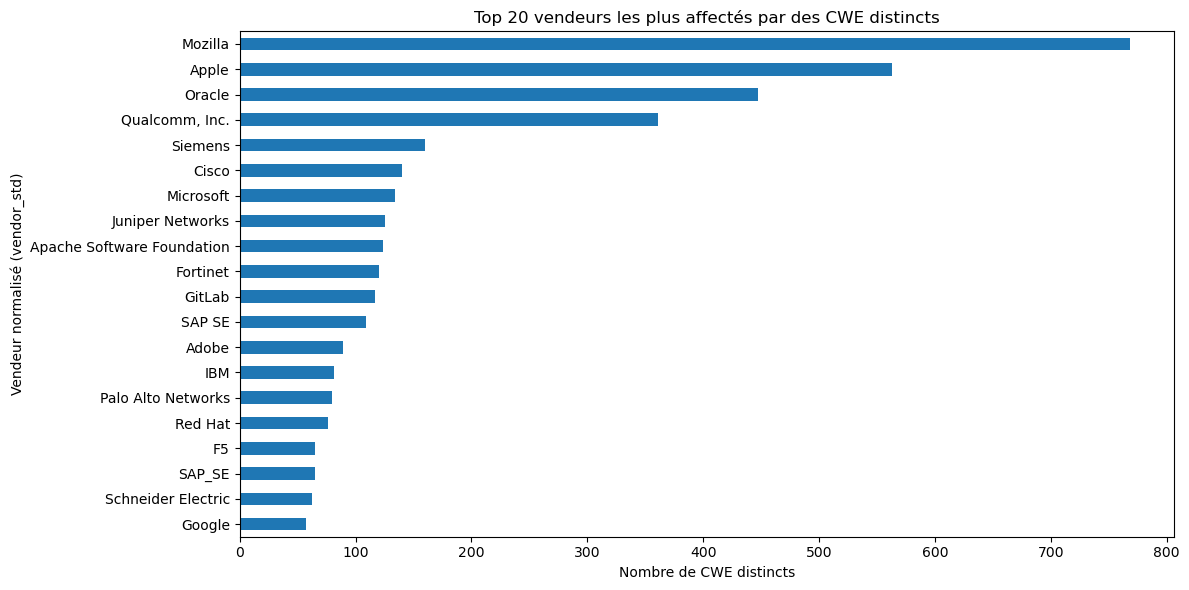

In [107]:
# On filtre les lignes ayant un vendor_std et une cwe valides
df_cwe = df_publi.dropna(subset=["vendor_std", "cwe"]).copy()

# Compte du nombre de CWE distincts par vendor_std
cwe_par_vendor = (
    df_cwe.groupby("vendor_std")["cwe"]
    .nunique()
    .sort_values(ascending=False)
    .head(20)
)

# Affichage du graphique
plt.figure(figsize=(12, 6))
cwe_par_vendor.plot(kind="barh")
plt.title("Top 20 vendeurs les plus affectés par des CWE distincts")
plt.xlabel("Nombre de CWE distincts")
plt.ylabel("Vendeur normalisé (vendor_std)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Histogramme de comparaison CVE totales vs CVE avec CWE

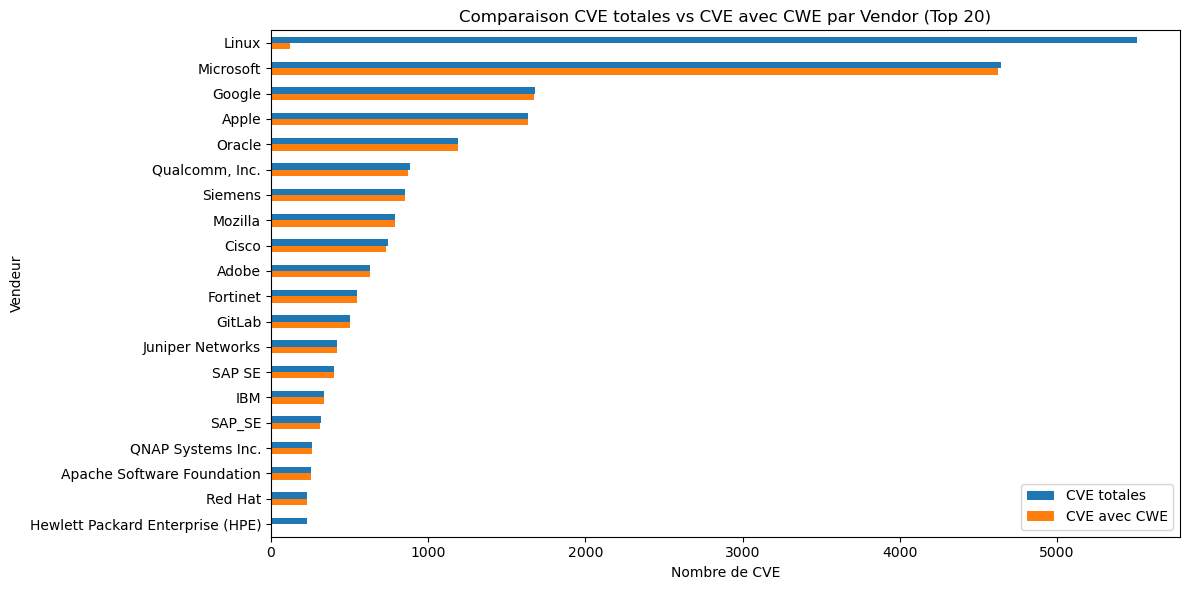

In [108]:
# 📌 On garde les lignes avec vendor_std et cve valides
df_valid = df_publi.dropna(subset=["vendor_std", "cve"]).copy()

# 📌 Nombre total de CVE distincts par vendeur
cve_par_vendor = df_valid.groupby("vendor_std")["cve"].nunique()

# 📌 Nombre de CVE distincts avec une CWE valide
df_with_cwe = df_valid.dropna(subset=["cwe"])
cve_avec_cwe_par_vendor = df_with_cwe.groupby("vendor_std")["cve"].nunique()

# 📌 Fusion des deux séries en DataFrame
df_comparatif = pd.DataFrame({
    "CVE_total": cve_par_vendor,
    "CVE_avec_CWE": cve_avec_cwe_par_vendor
}).fillna(0)

# 📌 Sélection des 20 vendeurs les plus affectés (par CVE_total)
top20 = df_comparatif.sort_values(by="CVE_total", ascending=False).head(20)

# 📈 Affichage
top20.plot(kind="barh", figsize=(12, 6))
plt.title("Comparaison CVE totales vs CVE avec CWE par Vendor (Top 20)")
plt.xlabel("Nombre de CVE")
plt.ylabel("Vendeur")
plt.gca().invert_yaxis()
plt.legend(["CVE totales", "CVE avec CWE"])
plt.tight_layout()
plt.show()


### Boxplot des scores CVSS par éditeur

Montrer **la dispersion des scores CVSS** pour les éditeurs les plus affectés.

<Figure size 900x600 with 0 Axes>

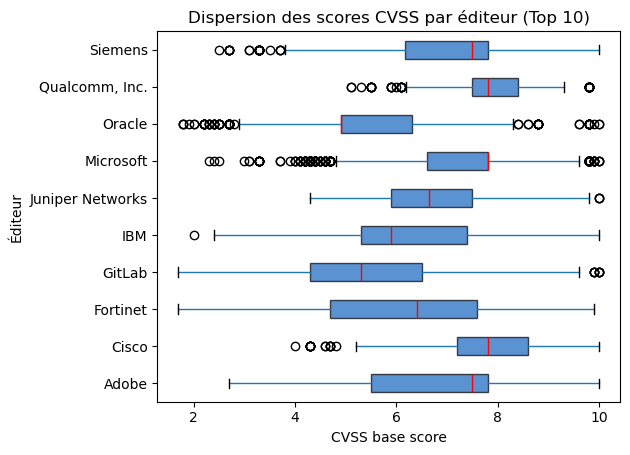

In [109]:
# On part de df_unique_all, puis on garde uniquement celles avec cvss_score
df_vendors = (
    df_unique_all
      .dropna(subset=["cvss_score"])
      .copy()
)

# Top 10 vendors en nombre de CVE
top_vendors = df_vendors["vendor_std"].value_counts().head(10).index

subset_top_vendors = df_vendors[df_vendors["vendor_std"].isin(top_vendors)]

# Boxplot horizontal
plt.figure(figsize=(9, 6))
subset_top_vendors.boxplot(
    column="cvss_score",
    by="vendor_std",
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="#1565C0", alpha=0.7),
    medianprops=dict(color="red"),
    vert=False,
)
plt.title("Dispersion des scores CVSS par éditeur (Top 10)")
plt.suptitle("")  # supprime le titre automatique
plt.xlabel("CVSS base score")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()


### Heat-map Vendor × CWE

/var/folders/yj/x9v30_4d7bx8sgt6m_3m2sk80000gn/T/ipykernel_1821/1767120678.py:39: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



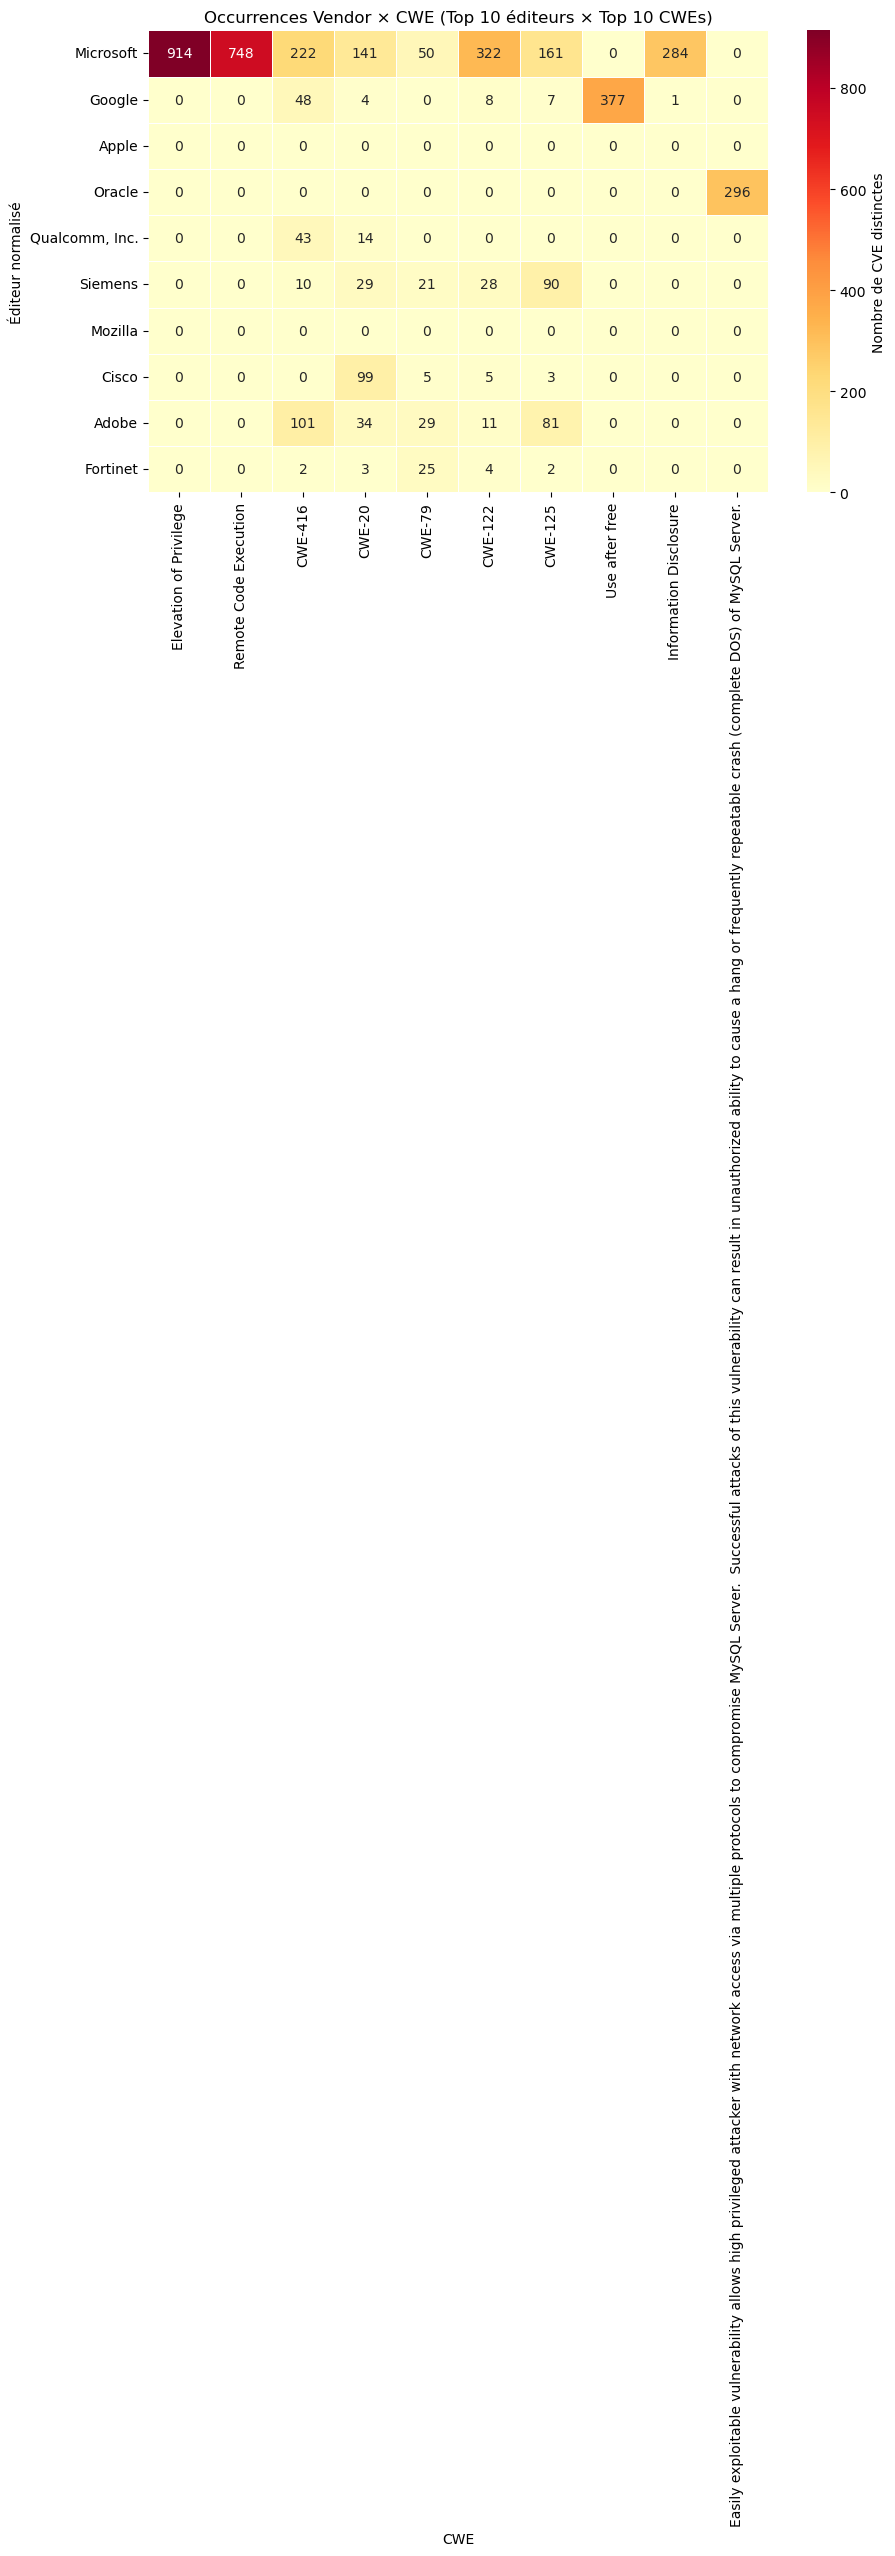

In [110]:
# 1) partir de df_unique_all + dropna sur vendor_std et cwe
df_vc = (
    df_unique_all
      .dropna(subset=["vendor_std", "cwe"])
      .copy()
)

# 2) top 10 vendors & top 10 CWE
top_vendors = df_vc["vendor_std"].value_counts().head(10).index
top_cwes    = df_vc["cwe"].value_counts().head(10).index

# 3) sous-ensemble raisonnable
sub = df_vc[
    df_vc["vendor_std"].isin(top_vendors) &
    df_vc["cwe"].isin(top_cwes)
]

# 4) matrice Vendor_std × CWE
pivot = (
    sub
      .groupby(["vendor_std", "cwe"])
      .size()
      .unstack(fill_value=0)
)

# 5) forcer l’ordre des lignes & colonnes
pivot = pivot.reindex(index=top_vendors, columns=top_cwes, fill_value=0)

# 6) tracé heat-map
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True, fmt="d", linewidths=.5,
    cmap="YlOrRd", cbar_kws={"label": "Nombre de CVE distinctes"}
)
plt.title("Occurrences Vendor × CWE (Top 10 éditeurs × Top 10 CWEs)")
plt.xlabel("CWE")
plt.ylabel("Éditeur normalisé")
plt.tight_layout()
plt.show()


### Top 3 vulnérabilités CWE pour les 10 principaux vendeurs

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the

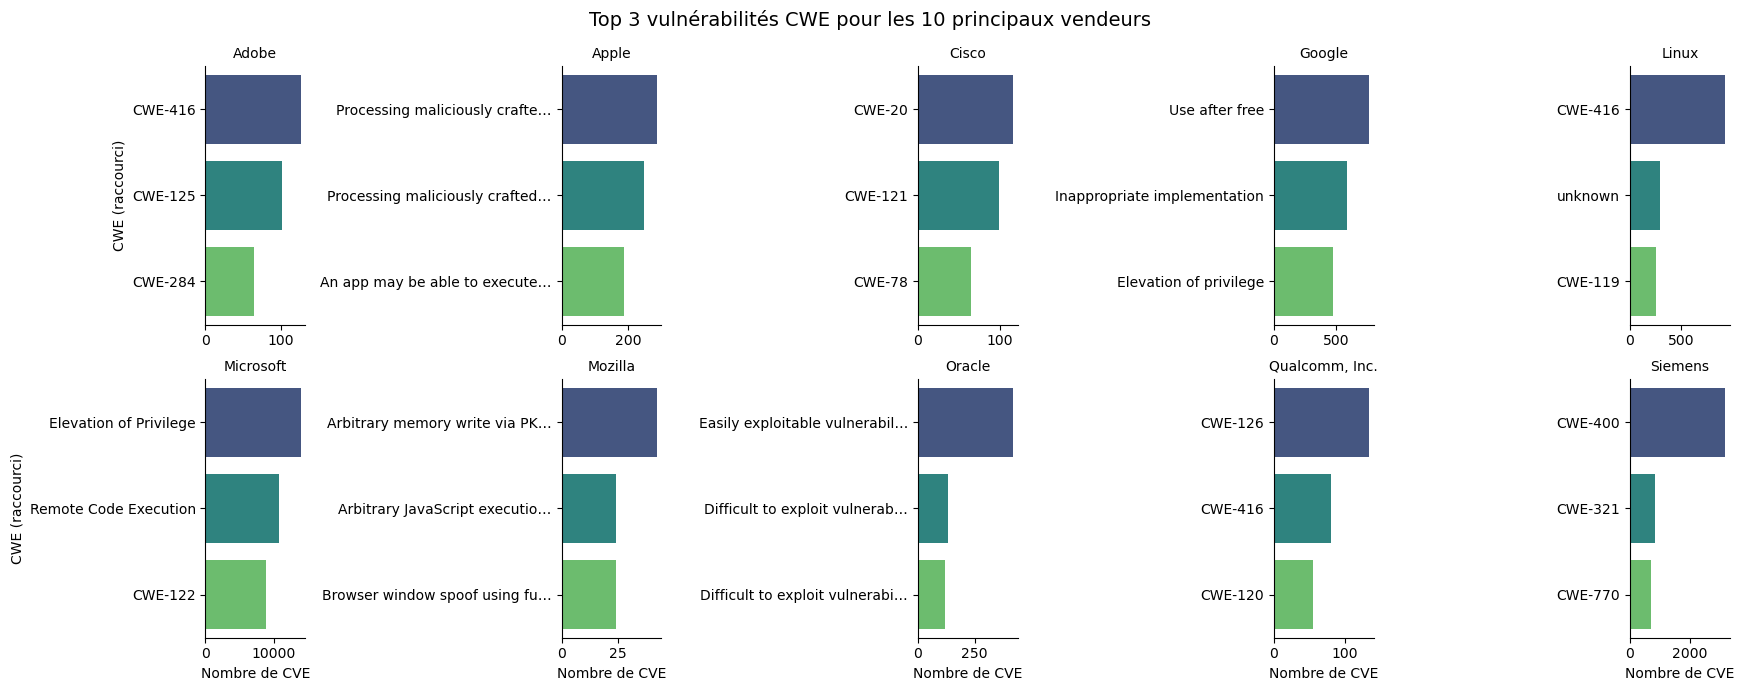

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Étape 1 : top-10 vendeurs
top_10_vendors = (
    df_publi.dropna(subset=["vendor_std", "cve"])
      .groupby("vendor_std")["cve"]
      .nunique()
      .sort_values(ascending=False)
      .head(10)
      .index
)

# 🔹 Étape 2 : lignes pertinentes
df_cwe_vendors = (
    df_publi[df_publi["vendor_std"].isin(top_10_vendors)]
      .dropna(subset=["cwe"])
)

# 🔹 Étape 3 : compte des CWE par vendeur
cwe_counts = (
    df_cwe_vendors
    .groupby(["vendor_std", "cwe"])
    .size()
    .reset_index(name="count")
)

# 🔹 Étape 4 : top-3 CWE par vendeur
top_cwes_per_vendor = (
    cwe_counts
    .sort_values(["vendor_std", "count"], ascending=[True, False])
    .groupby("vendor_std")
    .head(3)
)

# ───────────────────────────────────────────────────────────────
# 🔹 Étape 4 bis : création d'un label court mais unique
MAX_LEN = 30       # longueur cible « idéale »

def make_unique_short(series, max_len=MAX_LEN):
    """
    Pour chaque valeur de `series`, retourne une version raccourcie :
    - d'abord coupée à max_len ;
    - si doublon, on rallonge jusqu'à unicité (ou le nom complet).
    """
    used = set()
    short_list = []
    for full in series:
        # longueur courante que l'on peut faire évoluer
        cur_len = min(max_len, len(full))
        while True:
            short = full if len(full) <= cur_len else full[:cur_len-1] + "…"
            if short not in used:
                used.add(short)
                short_list.append(short)
                break
            # doublon → on révèle 1 caractère de plus
            if cur_len < len(full):
                cur_len += 1
            else:           # le nom entier est identique : on ne peut pas faire mieux
                # (cela ne devrait jamais arriver sauf si deux CWE identiques)
                short += " "  # force la différence
                used.add(short)
                short_list.append(short)
                break
    return short_list

top_cwes_per_vendor["cwe_short"] = (
    top_cwes_per_vendor
        .groupby("vendor_std")["cwe"]
        .transform(make_unique_short)
)

# ───────────────────────────────────────────────────────────────
# 🔹 Étape 5 : FacetGrid
g = sns.FacetGrid(
    top_cwes_per_vendor,
    col="vendor_std",
    col_wrap=5,
    height=3.5,
    sharex=False,
    sharey=False
)
g.map_dataframe(sns.barplot, y="cwe_short", x="count", palette="viridis")

# 🔹 Étape 6 : titres & labels
g.set_titles("{col_name}")
g.set_axis_labels("Nombre de CVE", "CWE (raccourci)")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Top 3 vulnérabilités CWE pour les 10 principaux vendeurs", fontsize=14)
plt.show()


### CVE / an pour les 5 éditeurs majeurs

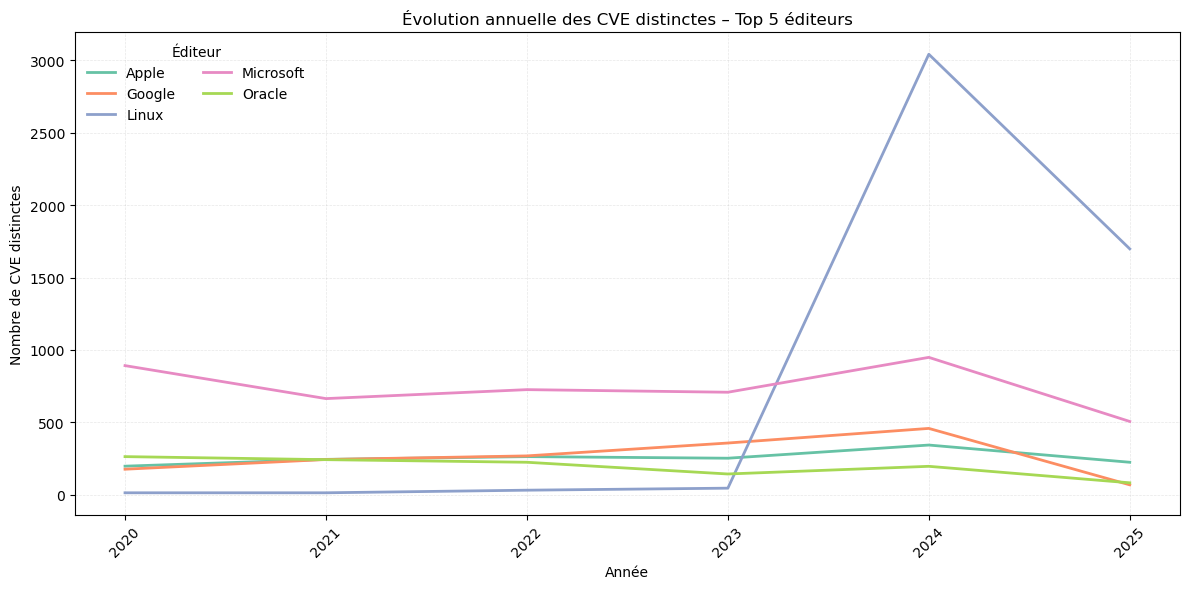

In [112]:
# ─── 0. Base fiable : une ligne par CVE (tout CVE unique, même sans scores)
df_unique_all = (
    df_publi
      .sort_values("date")
      .drop_duplicates(subset=["cve"])
      .copy()
)

# ─── 1. Préparation “clean” : on ne garde que les CVE avec vendor_std & date
clean = (
    df_unique_all
      .dropna(subset=["vendor_std", "date", "cve"])
      .assign(year=lambda d: d["date"].dt.year)
      .drop_duplicates(subset=["vendor_std", "cve"])  # une seule ligne par paire
)

# ─── 2. Top-5 éditeurs tous temps confondus
top5 = clean["vendor_std"].value_counts().head(5).index

# ─── 3. Comptage annuel par vendor_std
pivot = (
    clean[clean["vendor_std"].isin(top5)]
      .groupby(["year", "vendor_std"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# ─── 4. Remplir les années manquantes
full_years = pd.RangeIndex(pivot.index.min(), pivot.index.max() + 1)
pivot = pivot.reindex(full_years, fill_value=0)

# ─── 5. Tracé multi‐séries
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Set2", n_colors=len(top5))

for i, vendor in enumerate(pivot.columns):
    plt.plot(
        pivot.index,
        pivot[vendor],
        label=vendor,
        color=palette[i],
        linewidth=2
    )

plt.title("Évolution annuelle des CVE distinctes – Top 5 éditeurs")
plt.xlabel("Année")
plt.ylabel("Nombre de CVE distinctes")
plt.xticks(pivot.index, rotation=45)
plt.grid(alpha=0.3, linestyle="--", linewidth=0.5)
plt.legend(title="Éditeur", ncol=2, frameon=False)
plt.tight_layout()
plt.show()


## Analyse des bulletins et médiatisation

### Treemap des Bulletins, classé par type, date et nombre de produits affectés :

L'objectif de cette représentation est de dénicher les bulletins avec un impact "massifs", parfois sous-estimés, à travers l'évaluation du nombre de produits touchés par une vulnérabilité.

In [113]:
# ───────────── On part de df_publi ─────────────
df = df_publi.copy()

# ───────────── 1) Date limite ─────────────
date_limite = pd.Timestamp.now() - pd.DateOffset(months=4)

# ───────────── 2) Nombre de produits distincts PAR BULLETIN ─────────────
# (on considère ici la colonne 'produit' ; on pouvait aussi utiliser 'vendor_std' ou
# un couple (vendor_std, produit) si plusieurs produits par même éditeur)
df["n_affected_products"] = (
    df.groupby("id_anssi")["produit"]
      .transform("nunique")
)

# ───────────── 3) Une ligne par bulletin ─────────────
bulletins = (
    df[["type", "id_anssi", "date", "titre", "n_affected_products", "cvss_score", "epss_score"]]
      .drop_duplicates(subset=["id_anssi"])
)

# ───────────── 4) Top 200 bulletins les plus impactants ─────────────
top200 = bulletins.nlargest(200, "n_affected_products")

# ───────────── 5) Seuls les bulletins récents (derniers 4 mois) ─────────────
recent = top200[top200["date"] >= date_limite]

# ───────────── 6) Préparation des données pour la treemap ─────────────
treemap_data = (
    recent
      .sort_values("n_affected_products", ascending=False)
      .reset_index(drop=True)
)

# calcul du midpoint pour la palette
mid = np.average(
    treemap_data["n_affected_products"],
    weights=treemap_data["n_affected_products"]
)

# ───────────── 7) Tracé avec Plotly Express ─────────────
fig = px.treemap(
    treemap_data,
    path=["type", "date", "id_anssi", "titre"],
    values="n_affected_products",
    color="n_affected_products",
    color_continuous_scale="RdBu",
    color_continuous_midpoint=mid,
    title="Treemap des bulletins récents – impact (n° produits affectés)"
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

# Trouver le bulletin avec le plus grand nombre de produits affectés
bulletin_max_impact = treemap_data.loc[treemap_data['n_affected_products'].idxmax()]

# Afficher les informations du bulletin de manière plus lisible
print("Bulletin avec le plus grand impact :")
print(f"Type : {bulletin_max_impact['type']}")
print(f"ID ANSSI : {bulletin_max_impact['id_anssi']}")
print(f"Date : {bulletin_max_impact['date'].strftime('%Y-%m-%d')}")
print(f"Titre : {bulletin_max_impact['titre']}")
print(f"Nombre de produits affectés : {bulletin_max_impact['n_affected_products']}")
print(f"Score CVSS : {bulletin_max_impact['cvss_score'] if not pd.isna(bulletin_max_impact['cvss_score']) else 'Non disponible'}")
print(f"Score EPSS : {bulletin_max_impact['epss_score'] if not pd.isna(bulletin_max_impact['epss_score']) else 'Non disponible'}")

/opt/anaconda3/lib/python3.12/site-packages/plotly/express/_core.py:1991: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Bulletin avec le plus grand impact :
Type : avis
ID ANSSI : CERTFR-2025-AVI-0284
Date : 2025-04-08
Titre : Multiples vulnérabilités dans les produits Siemens
Nombre de produits affectés : 156
Score CVSS : 9.8
Score EPSS : 0.00217


Cette représentation permet de mettre en évidence les bulletins qui ont un impact large, créant un nouveau moyen de cibler les vulnérabilités à traiter.

Ici, nous observons par exemple que, sur les 4 derniers mois, le bulletin CERTFR-2025-AVI-0481, est le bulletin impactant le plus de produit. Cependant, en cherchant les détails de cet avis, nous remarquons que ses scores CVSS et EPSS sont bas. Ce bulletin aurait donc pu passer "sous le radar" puisque les mesures de son urgence sont faibles, bien que son impact soit probablement important.

###  

### Nuage de point (scatter), Nombre de références x Score EPSS :

L'étude de la relation entre le nombre de références d'un bulletin et son score EPSS nous permet de mettre en perspective le rôle de la popularité/médiatisation d'un bulletin dans l'évaluation de l'urgence de traitement. L'hypothèse soulevée est que : plus de sources implique un risque médiatique et une exploitation probable.

Nous utilisons un tableau complémentaire pour évaluer des points d'intérêts (nombre de références élevé), selon leur niveau de danger et d'urgence de traitement.

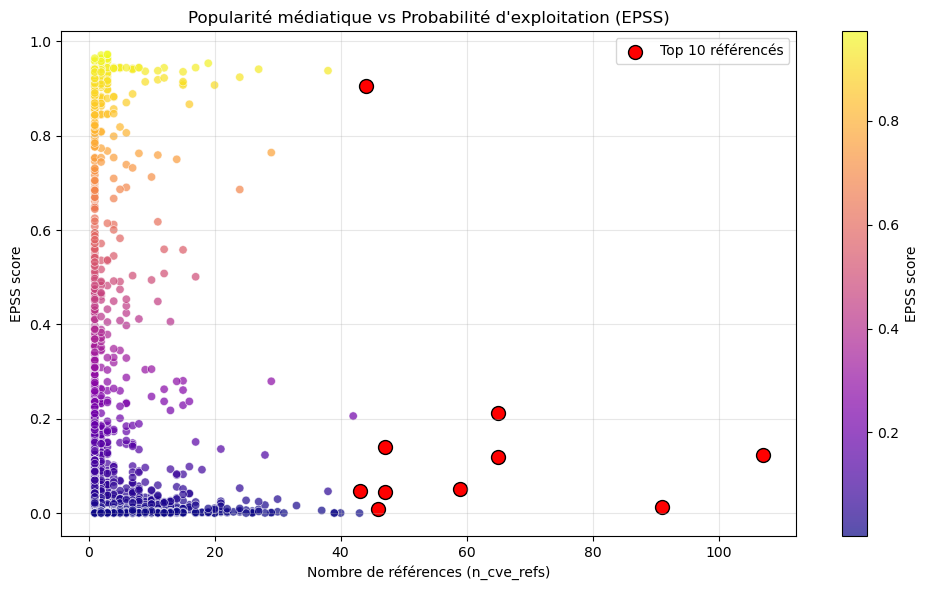

🔝 Top 10 des CVE les plus référencées :
╒════════╤════════════════╤══════════════╤══════════════╤══════════════╤════════════╕
│        │ cve            │   n_cve_refs │   epss_score │   cvss_score │ cvss_sev   │
╞════════╪════════════════╪══════════════╪══════════════╪══════════════╪════════════╡
│ 220281 │ CVE-2021-28165 │          107 │        0.123 │        7.500 │ HIGH       │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│ 229792 │ CVE-2021-21295 │           91 │        0.013 │        5.900 │ MEDIUM     │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│ 256190 │ CVE-2019-9512  │           65 │        0.212 │        7.500 │ HIGH       │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│ 251099 │ CVE-2020-11023 │           65 │        0.118 │        6.900 │ MEDIUM     │
├────────┼────────────────┼──────────────┼──────────────┼──────────────┼────────────┤
│ 229783 │ CVE

In [114]:
# 1️⃣ On part de df_unique_scores (une ligne par CVE, CVSS+EPSS présents)
df = df_unique_scores.copy()

# 2️⃣ On s’assure d’avoir bien les deux colonnes
df = df.dropna(subset=["n_cve_refs", "epss_score"])

# 3️⃣ On repère les 10 CVE les plus citées
top_referenced = df.nlargest(10, "n_cve_refs")

# 4️⃣ Nuage de points
plt.figure(figsize=(10, 6))

# tout le nuage en fond (couleur = EPSS)
sc = plt.scatter(
    df["n_cve_refs"],
    df["epss_score"],
    c=df["epss_score"],
    cmap="plasma",
    alpha=0.7,
    edgecolors="white",
    linewidths=0.5
)

# mises en évidence des top 10
plt.scatter(
    top_referenced["n_cve_refs"],
    top_referenced["epss_score"],
    color="red",
    edgecolors="black",
    s=100,
    label="Top 10 référencés"
)

plt.colorbar(sc, label="EPSS score")
plt.xlabel("Nombre de références (n_cve_refs)")
plt.ylabel("EPSS score")
plt.title("Popularité médiatique vs Probabilité d'exploitation (EPSS)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5️⃣ Tableau des top 10
print("🔝 Top 10 des CVE les plus référencées :")
print(tabulate(
    top_referenced[["cve", "n_cve_refs", "epss_score", "cvss_score", "cvss_sev"]],
    headers="keys",
    tablefmt="fancy_grid",
    floatfmt=".3f"
))

Le graphe que nous obtenons met en évidence une tendance : es bulletins avec un nombre de références élevés sont pour la plupart dotés d'un score EPSS faible. En effet, on constate sur notre nuage de point que, si quelques bulletins avec un score EPSS élevé ont un nombre de références un peu plus élevé que la moyenne, les bulletins les plus référencés ont un score EPSS faible.

En analysant plus précisément ces points d'intérêts grâce au tableau complémentaire, nous remarquons que, si le score EPSS de ces points est faible, leur sévérité CVSS est variée et peut souvent être élevée comme pour le bulletin, CVE-2020-5398, avec un score CVSS de **8**.

Ce graphique permet de montrer que la popularité/médiatisation d'un bulletin, est un critère à part de l'évaluation des risques. Notre hypothèse n'est donc pas validée par cette visualisation, qui montre peut-être que la popularité et la médiatisation d'un bulletin est sous-estimé par le score EPSS.

###  

### Nuage de point (scatter) comparant, nombre de révisions x Score EPSS :

À travers cette visualisation, on cherche à déterminer si le nombre de révisions d'un bulletin ANSSI permet d'indiquer une autre dimension d'urgence de risque.

Nous utilisons un tableau complémentaire, associé aux points d'intérêts (EPSS modéré x Révisions nombreuses), pour évaluer les risques globaux de ces derniers.

Top 10 des bulletins avec EPSS < 0.5 :
╒═══════╤═════════════════════╤════════════════╤═══════════════╤══════════════╤══════════════╤════════════╕
│       │ id_anssi            │ cve            │   n_revisions │   epss_score │   cvss_score │ cvss_sev   │
╞═══════╪═════════════════════╪════════════════╪═══════════════╪══════════════╪══════════════╪════════════╡
│ 91246 │ CERTFR-2024-ALE-001 │ CVE-2024-21888 │            12 │        0.001 │        8.800 │ HIGH       │
├───────┼─────────────────────┼────────────────┼───────────────┼──────────────┼──────────────┼────────────┤
│ 91248 │ CERTFR-2024-ALE-001 │ CVE-2024-22024 │            12 │        0.015 │        8.300 │ HIGH       │
├───────┼─────────────────────┼────────────────┼───────────────┼──────────────┼──────────────┼────────────┤
│ 91615 │ CERTFR-2021-ALE-014 │ CVE-2021-34481 │            11 │        0.004 │        8.800 │ HIGH       │
├───────┼─────────────────────┼────────────────┼───────────────┼──────────────┼──────────────┼───

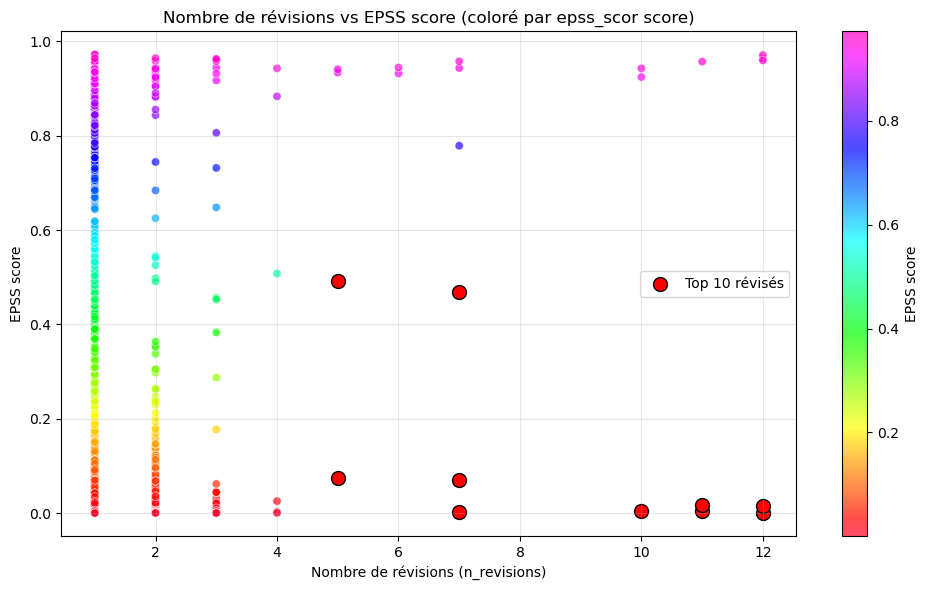

In [115]:
plt.figure(figsize=(10, 6))

# Filtrer les bulletins avec un EPSS inférieur à 0.5
filtered_bulletins = df_unique_scores[df_unique_scores["epss_score"] < 0.5]

# Sélectionner le top 10 des bulletins par nombre de révisions
top_10_revisions = filtered_bulletins.nlargest(10, "n_revisions")

# Afficher les résultats
print("Top 10 des bulletins avec EPSS < 0.5 :")
print(tabulate(
    top_10_revisions[["id_anssi", "cve", "n_revisions", "epss_score", "cvss_score", "cvss_sev"]],
    headers="keys",
    tablefmt="fancy_grid",
    floatfmt=".3f"
))

# nuage de points
scatter = plt.scatter(
    df_unique_scores["n_revisions"],
    df_unique_scores["epss_score"],
    c=df_unique_scores["epss_score"],  # couleur = CVSS
    cmap="gist_rainbow",
    alpha=0.7,
    edgecolors="white",
    linewidths=0.5
)

# surligner les top 10
plt.scatter(
    top_10_revisions["n_revisions"],
    top_10_revisions["epss_score"],
    c="red",
    edgecolors="black",
    label="Top 10 révisés",
    s=100,
)

plt.colorbar(scatter, label="EPSS score")
plt.xlabel("Nombre de révisions (n_revisions)")
plt.ylabel("EPSS score")
plt.title("Nombre de révisions vs EPSS score (coloré par epss_scor score)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Sur le nuage de points, nous remarquons deux phénomènes :

**1.**  Les bulletins avec un score EPSS élevé sont aussi ceux avec un nombre de révision élevé. En effet les bulletins avec un nombre de révisions de **10 à 12** sont placés au-dessus d'un score EPSS de **0.8**, attestant de la corrélation entre urgence de traitement d'une vulnérabilité (score EPSS élevé) avec le nombre de révisions de son bulletin.

**2.**  Des bulletins qu'on peut considérer comme "outliers", avec un score EPSS faible (**< 0.5 voir < 0.2**), ont un nombre de révisions plus élevé que la normale, allant jusqu'à **7** pour les cas : CERTFR-2021-ALE-004 et CERTFR-2021-ALE-014. Ces cas nous intéressent car, grâce au tableau complémentaire, nous constatons que leur sévérité cvss est élevée voire critique.

Ainsi, prendre en compte le nombre de révisions d'un bulletin peut fournir un outil pour gérer les situations où le traitement du backlog est complexe, où des données de risques sont manquantes.

###   

## **Résultats du modèle de classification (Random Forest)**

Nous avons entraîné un modèle de type Random Forest pour prédire la gravité (cvss_sev) d’une vulnérabilité à partir de plusieurs variables : le score CVSS, le score EPSS, le percentile EPSS et le nombre de jours depuis la publication (days_open).

Les résultats obtenus sont très bons. Le rapport de classification montre une précision, un rappel et un score F1 de 1.00 pour les classes principales : CRITICAL, HIGH, MEDIUM et LOW. Seule la classe NONE est un peu moins bien prédite. Cela s’explique par le fait qu’elle ne contient que deux exemples dans l’ensemble de test, ce qui rend l’évaluation peu représentative.

La matrice de confusion confirme ces performances. Le modèle classe correctement presque toutes les observations. On observe une seule confusion entre la classe LOW et NONE, ce qui est négligeable par rapport au nombre total d’exemples.

**Interprétation des résultats**

Ces résultats montrent que le modèle est capable de prédire de manière fiable la gravité d’une vulnérabilité, même lorsqu’elle n’est pas fournie directement. Les variables utilisées sont suffisamment informatives pour permettre une bonne séparation entre les classes.

Cela est très utile dans notre projet, car certaines vulnérabilités ne sont pas toujours accompagnées d’un niveau de gravité clair. Grâce à ce modèle, nous pouvons estimer ce niveau automatiquement.

**Utilité pour la suite du projet**

L’intégration de ce modèle dans notre pipeline permet de renforcer le système de détection des vulnérabilités critiques. Lorsqu’une faille est prédite comme critique par le modèle, même si elle n’est pas encore officiellement classée, une alerte peut être déclenchée.

Par exemple, si une CVE présente un score EPSS élevé mais n’a pas encore de gravité assignée, le modèle peut prédire qu’elle est critique. Cela permet d’envoyer une notification sans attendre les mises à jour officielles.

## **Résultats du modèle de regroupement (KMeans)**

Nous avons utilisé l’algorithme KMeans pour regrouper les vulnérabilités en fonction de leurs caractéristiques, sans utiliser d’étiquette de gravité. C’est une méthode non supervisée, qui cherche à créer des groupes d’éléments similaires.

Avant d’appliquer le modèle, nous avons réduit le nombre de dimensions grâce à une analyse en composantes principales (PCA). Cela permet de visualiser les données sur un graphique en deux dimensions.

Le graphique obtenu montre plusieurs groupes bien distincts. Chaque couleur représente un groupe (ou cluster) de vulnérabilités qui partagent des caractéristiques communes.
Interprétation des résultats

Les résultats montrent que les vulnérabilités peuvent être classées automatiquement en différents groupes. Chaque groupe contient des vulnérabilités qui se ressemblent :
- Un groupe peut contenir des vulnérabilités très graves, avec un score élevé et un fort risque d’exploitation.
- Un autre groupe peut regrouper des failles moins graves ou plus anciennes.
- Certains groupes sont très compacts (vulnérabilités très similaires), d'autres plus dispersés (vulnérabilités plus variées).

Cela permet de mieux comprendre les types de vulnérabilités présents dans les données.

**Utilité pour le projet**

Ce modèle est très utile pour notre projet. Il nous permet de :
classer automatiquement les vulnérabilités, même quand nous ne connaissons pas encore leur gravité, d'identifier les groupes les plus à risque, pour mieux prioriser les actions à mener, et enfin repérer des anomalies, c’est-à-dire des failles qui ne ressemblent à aucune autre.

Par exemple, si un groupe contient souvent des vulnérabilités critiques, alors toutes les nouvelles failles qui entrent dans ce groupe doivent être surveillées de près.